# 3D CNN

Basic + Augmentations (invert, rotate, zoom, blur, noise) + Batch Norm + Dropout (0.05)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
# import tensorflow as tf

# RANDOM_SEED = 792379571013149
# tf.random.set_seed(RANDOM_SEED)

# print(tf.version.VERSION)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

## Setup

In [4]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201230-124857
Wall time: 5 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.05,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00020,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 60,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.20),
        'shear': (0, 0), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Train

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [13]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201230-113943', 'cp-0001.ckpt')

loading checkpoint from ../../tmp\checkpoints\20201230-113943\cp-0001.ckpt...

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x0000026A063EEFC8> and <tensorflow.python.keras.layers.core.Dropout object at 0x0000026A063E1BC8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x0000026A063F7308> and <tensorflow.python.keras.layers.core.Dense object at 0x0000026A063EEFC8>).


In [14]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [15]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201230-124857
checkpoint dir: ../../tmp\checkpoints\20201230-124857
log dir: ../../tmp\logs\20201230-124857
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
51/51 [==============================] - ETA: 0s - loss: 1.2086 - recall: 0.5274 - precision: 0.5274 - auc: 0.5096 - categorical_accuracy: 0.5274
Epoch 00001: val_auc improved from -inf to 0.39560, saving model to ../../tmp\checkpoints\20201230-124857\cp-0001.ckpt
51/51 [==============================] - 25s 496ms/step - loss: 1.2086 - recall: 0.5274 - precision: 0.5274 - auc: 0.5096 - categorical_accuracy: 0.5274 - val_loss: 0.9173 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.3956 - val_categorical_accuracy: 0.3800
Epoch 2/200
51/51 [==============================] - ETA: 0s - loss: 1.1071 - recall: 0.5448 - precision: 0.5448 - auc: 0.5213 - categorical_accuracy: 0.5448
Epoch 00002: val_auc i

Epoch 17/200
51/51 [==============================] - ETA: 0s - loss: 0.6001 - recall: 0.6866 - precision: 0.6866 - auc: 0.7387 - categorical_accuracy: 0.6866
Epoch 00017: val_auc did not improve from 0.74180
51/51 [==============================] - 23s 459ms/step - loss: 0.6001 - recall: 0.6866 - precision: 0.6866 - auc: 0.7387 - categorical_accuracy: 0.6866 - val_loss: 0.6508 - val_recall: 0.5400 - val_precision: 0.5400 - val_auc: 0.5804 - val_categorical_accuracy: 0.5400
Epoch 18/200
51/51 [==============================] - ETA: 0s - loss: 0.5636 - recall: 0.7139 - precision: 0.7139 - auc: 0.7858 - categorical_accuracy: 0.7139
Epoch 00018: val_auc did not improve from 0.74180
51/51 [==============================] - 23s 460ms/step - loss: 0.5636 - recall: 0.7139 - precision: 0.7139 - auc: 0.7858 - categorical_accuracy: 0.7139 - val_loss: 0.6502 - val_recall: 0.5400 - val_precision: 0.5400 - val_auc: 0.5815 - val_categorical_accuracy: 0.5400
Epoch 19/200
51/51 [======================

51/51 [==============================] - ETA: 0s - loss: 0.4918 - recall: 0.7711 - precision: 0.7711 - auc: 0.8620 - categorical_accuracy: 0.7711
Epoch 00034: val_auc did not improve from 0.74180
51/51 [==============================] - 23s 458ms/step - loss: 0.4918 - recall: 0.7711 - precision: 0.7711 - auc: 0.8620 - categorical_accuracy: 0.7711 - val_loss: 0.6501 - val_recall: 0.5200 - val_precision: 0.5200 - val_auc: 0.5891 - val_categorical_accuracy: 0.5200
Epoch 35/200
51/51 [==============================] - ETA: 0s - loss: 0.5073 - recall: 0.7562 - precision: 0.7562 - auc: 0.8482 - categorical_accuracy: 0.7562
Epoch 00035: val_auc did not improve from 0.74180
51/51 [==============================] - 23s 458ms/step - loss: 0.5073 - recall: 0.7562 - precision: 0.7562 - auc: 0.8482 - categorical_accuracy: 0.7562 - val_loss: 0.6499 - val_recall: 0.5200 - val_precision: 0.5200 - val_auc: 0.5905 - val_categorical_accuracy: 0.5200
Epoch 36/200
51/51 [==============================] - E

Epoch 51/200
51/51 [==============================] - ETA: 0s - loss: 0.4441 - recall: 0.8234 - precision: 0.8234 - auc: 0.9100 - categorical_accuracy: 0.8234
Epoch 00051: val_auc improved from 0.76810 to 0.77090, saving model to ../../tmp\checkpoints\20201230-124857\cp-0051.ckpt
51/51 [==============================] - 24s 463ms/step - loss: 0.4441 - recall: 0.8234 - precision: 0.8234 - auc: 0.9100 - categorical_accuracy: 0.8234 - val_loss: 0.5808 - val_recall: 0.7300 - val_precision: 0.7300 - val_auc: 0.7709 - val_categorical_accuracy: 0.7300
Epoch 52/200
51/51 [==============================] - ETA: 0s - loss: 0.4427 - recall: 0.8433 - precision: 0.8433 - auc: 0.9140 - categorical_accuracy: 0.8433
Epoch 00052: val_auc did not improve from 0.77090
51/51 [==============================] - 24s 462ms/step - loss: 0.4427 - recall: 0.8433 - precision: 0.8433 - auc: 0.9140 - categorical_accuracy: 0.8433 - val_loss: 0.5798 - val_recall: 0.7200 - val_precision: 0.7200 - val_auc: 0.7670 - val

Epoch 68/200
51/51 [==============================] - ETA: 0s - loss: 0.4410 - recall: 0.8557 - precision: 0.8557 - auc: 0.9157 - categorical_accuracy: 0.8557
Epoch 00068: val_auc did not improve from 0.77535
51/51 [==============================] - 25s 489ms/step - loss: 0.4410 - recall: 0.8557 - precision: 0.8557 - auc: 0.9157 - categorical_accuracy: 0.8557 - val_loss: 0.5777 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7736 - val_categorical_accuracy: 0.7500
Epoch 69/200
51/51 [==============================] - ETA: 0s - loss: 0.4512 - recall: 0.8333 - precision: 0.8333 - auc: 0.9075 - categorical_accuracy: 0.8333
Epoch 00069: val_auc did not improve from 0.77535
51/51 [==============================] - 26s 501ms/step - loss: 0.4512 - recall: 0.8333 - precision: 0.8333 - auc: 0.9075 - categorical_accuracy: 0.8333 - val_loss: 0.5781 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7747 - val_categorical_accuracy: 0.7500
Epoch 70/200
51/51 [======================

Epoch 85/200
51/51 [==============================] - ETA: 0s - loss: 0.4520 - recall: 0.8184 - precision: 0.8184 - auc: 0.9050 - categorical_accuracy: 0.8184
Epoch 00085: val_auc did not improve from 0.77900
51/51 [==============================] - 25s 490ms/step - loss: 0.4520 - recall: 0.8184 - precision: 0.8184 - auc: 0.9050 - categorical_accuracy: 0.8184 - val_loss: 0.5777 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7778 - val_categorical_accuracy: 0.7500
Epoch 86/200
51/51 [==============================] - ETA: 0s - loss: 0.4454 - recall: 0.8109 - precision: 0.8109 - auc: 0.9110 - categorical_accuracy: 0.8109
Epoch 00086: val_auc did not improve from 0.77900
51/51 [==============================] - 25s 495ms/step - loss: 0.4454 - recall: 0.8109 - precision: 0.8109 - auc: 0.9110 - categorical_accuracy: 0.8109 - val_loss: 0.5776 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7774 - val_categorical_accuracy: 0.7500
Epoch 87/200
51/51 [======================

51/51 [==============================] - ETA: 0s - loss: 0.4294 - recall: 0.8408 - precision: 0.8408 - auc: 0.9258 - categorical_accuracy: 0.8408
Epoch 00102: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 457ms/step - loss: 0.4294 - recall: 0.8408 - precision: 0.8408 - auc: 0.9258 - categorical_accuracy: 0.8408 - val_loss: 0.5774 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7777 - val_categorical_accuracy: 0.7500
Epoch 103/200
51/51 [==============================] - ETA: 0s - loss: 0.4339 - recall: 0.8308 - precision: 0.8308 - auc: 0.9190 - categorical_accuracy: 0.8308
Epoch 00103: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 457ms/step - loss: 0.4339 - recall: 0.8308 - precision: 0.8308 - auc: 0.9190 - categorical_accuracy: 0.8308 - val_loss: 0.5774 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7784 - val_categorical_accuracy: 0.7500
Epoch 104/200
51/51 [==============================] -

51/51 [==============================] - ETA: 0s - loss: 0.4329 - recall: 0.8259 - precision: 0.8259 - auc: 0.9249 - categorical_accuracy: 0.8259
Epoch 00119: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 457ms/step - loss: 0.4329 - recall: 0.8259 - precision: 0.8259 - auc: 0.9249 - categorical_accuracy: 0.8259 - val_loss: 0.5774 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7777 - val_categorical_accuracy: 0.7500
Epoch 120/200
51/51 [==============================] - ETA: 0s - loss: 0.4482 - recall: 0.8085 - precision: 0.8085 - auc: 0.8992 - categorical_accuracy: 0.8085
Epoch 00120: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 458ms/step - loss: 0.4482 - recall: 0.8085 - precision: 0.8085 - auc: 0.8992 - categorical_accuracy: 0.8085 - val_loss: 0.5775 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7777 - val_categorical_accuracy: 0.7500
Epoch 121/200
51/51 [==============================] -

51/51 [==============================] - ETA: 0s - loss: 0.4323 - recall: 0.8383 - precision: 0.8383 - auc: 0.9167 - categorical_accuracy: 0.8383
Epoch 00136: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 457ms/step - loss: 0.4323 - recall: 0.8383 - precision: 0.8383 - auc: 0.9167 - categorical_accuracy: 0.8383 - val_loss: 0.5771 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7768 - val_categorical_accuracy: 0.7500
Epoch 137/200
51/51 [==============================] - ETA: 0s - loss: 0.4387 - recall: 0.8209 - precision: 0.8209 - auc: 0.9108 - categorical_accuracy: 0.8209
Epoch 00137: val_auc did not improve from 0.77900
51/51 [==============================] - 23s 458ms/step - loss: 0.4387 - recall: 0.8209 - precision: 0.8209 - auc: 0.9108 - categorical_accuracy: 0.8209 - val_loss: 0.5773 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7779 - val_categorical_accuracy: 0.7500
Epoch 138/200
51/51 [==============================] -

## Evaluation

Wall time: 159 ms


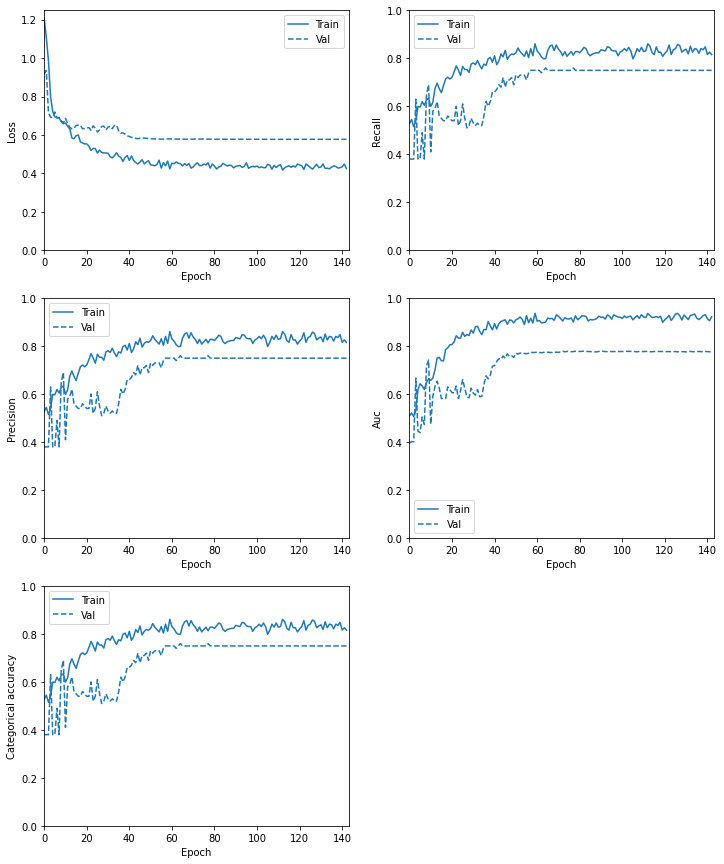

In [16]:
%%time

plot_training_history(history)

In [17]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.569075345993042
recall: 0.75
precision: 0.75
auc: 0.7789999842643738
categorical_accuracy: 0.75

Wall time: 23.8 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8245614035087719
recall: 0.7580645161290323
f1-score: 0.7899159663865545
support: 62


CN
precision: 0.6511627906976745
recall: 0.7368421052631579
f1-score: 0.6913580246913581
support: 38


micro avg
precision: 0.75
recall: 0.75
f1-score: 0.75
support: 100


macro avg
precision: 0.7378620971032233
recall: 0.747453310696095
f1-score: 0.7406369955389562
support: 100


weighted avg
precision: 0.7586699306405549
recall: 0.75
f1-score: 0.7524639485423799
support: 100


samples avg
precision: 0.75
recall: 0.75
f1-score: 0.75
support: 100


F1
micro: 0.75
macro: 0.7406369955389562


accuracy_score: 0.75
sensitivity_score: 0.7580645161290323
specificity_score: 0.7368421052631579


Wall time: 23.5 s


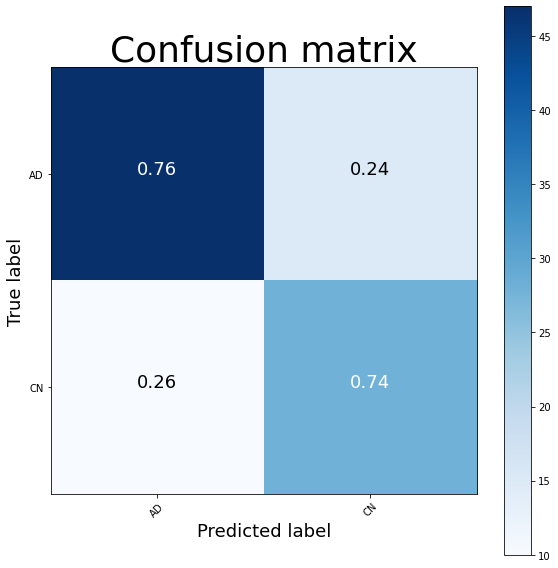

In [18]:
%%time

show_metrics(model, test_seq, class_names)